In [35]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import joblib


In [36]:
df = pd.read_csv('../data/cleaned_retail.csv', parse_dates=['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [37]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm['Churn'] = (rfm['Recency'] > 180).astype(int)


In [38]:
total_products = df.groupby('Customer ID')['Quantity'].sum().reset_index(name='TotalProductsPurchased')
unique_products = df.groupby('Customer ID')['Description'].nunique().reset_index(name='UniqueProducts')

basket_size = df.groupby('Customer ID').agg({
    'TotalPrice': 'sum',
    'Invoice': 'nunique'
}).reset_index()
basket_size['AvgBasketSize'] = basket_size['TotalPrice'] / basket_size['Invoice']

invoice_dates = df.groupby('Customer ID')['InvoiceDate'].agg(['min', 'max', 'count']).reset_index()
invoice_dates['AvgDaysBetweenPurchases'] = invoice_dates.apply(
    lambda row: (row['max'] - row['min']).days / (row['count'] - 1) if row['count'] > 1 else 0,
    axis=1
)
invoice_dates['DaysSinceFirstPurchase'] = (snapshot_date - invoice_dates['min']).dt.days

df['IsCancelled'] = df['Invoice'].astype(str).str.startswith('C').astype(int)
cancellation_rate = df.groupby('Customer ID')['IsCancelled'].mean().reset_index(name='CancellationRate')

rfm = rfm.merge(total_products, on='Customer ID', how='left') \
         .merge(unique_products, on='Customer ID', how='left') \
         .merge(basket_size[['Customer ID', 'AvgBasketSize']], on='Customer ID', how='left') \
         .merge(invoice_dates[['Customer ID', 'AvgDaysBetweenPurchases', 'DaysSinceFirstPurchase']], on='Customer ID', how='left') \
         .merge(cancellation_rate, on='Customer ID', how='left')

rfm.fillna(0, inplace=True)


In [39]:
features = [
    'Frequency', 'Monetary', 'TotalProductsPurchased',
    'UniqueProducts', 'AvgBasketSize', 'AvgDaysBetweenPurchases',
    'DaysSinceFirstPurchase', 'CancellationRate'
]

X = rfm[features]
y = rfm['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)

# Predictions
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]


Confusion Matrix:
 [[1008   36]
 [  50  671]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1044
           1       0.95      0.93      0.94       721

    accuracy                           0.95      1765
   macro avg       0.95      0.95      0.95      1765
weighted avg       0.95      0.95      0.95      1765

ROC-AUC Score: 0.9905450072005143


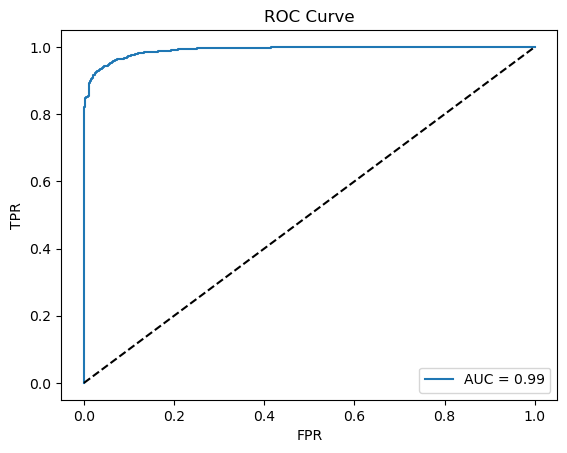

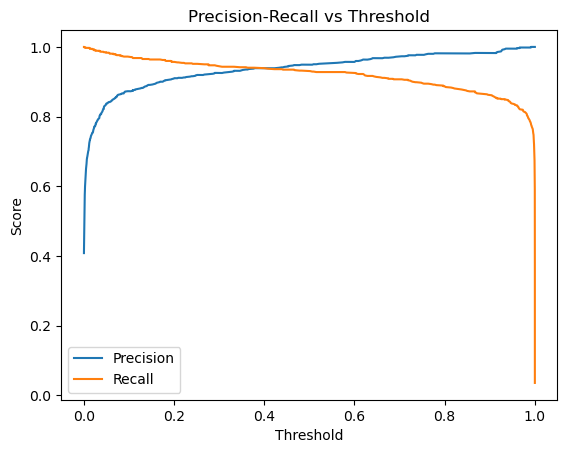

In [40]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.show()


In [41]:
joblib.dump(xgb, '../model/churn_model_xgb.pkl')


['../model/churn_model_xgb.pkl']

In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(xgb, X_train_res, y_train_res, cv=5, scoring='roc_auc')


array([0.98773027, 0.98859885, 0.99152503, 0.99318629, 0.99228398])

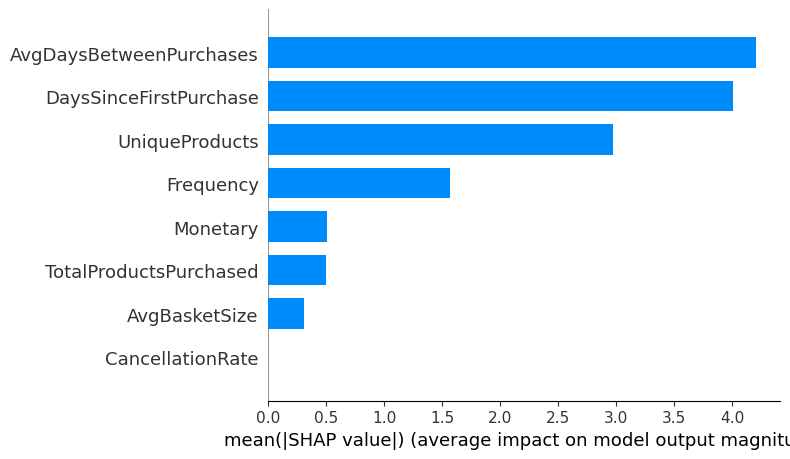

In [43]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


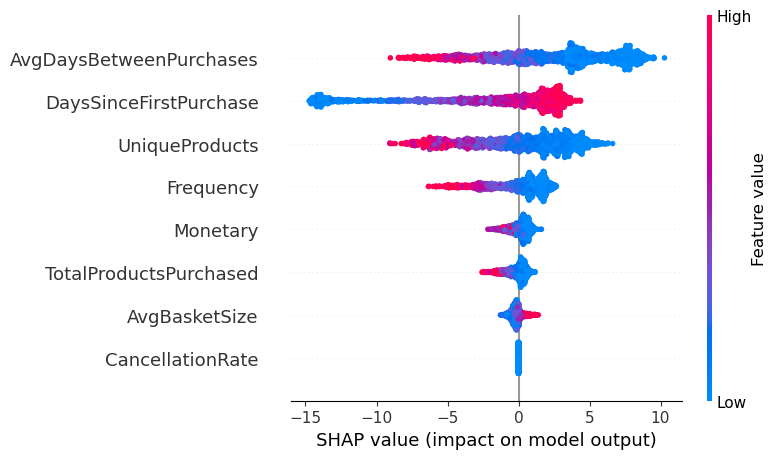

In [44]:
shap.summary_plot(shap_values, X_test)


In [30]:
!pip install lightgbm


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/jsonpointer-3.0.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00


[LightGBM] [Info] Number of positive: 2435, number of negative: 2435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1577
[LightGBM] [Info] Number of data points in the train set: 4870, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
 LightGBM Results
Confusion Matrix:
 [[1011   33]
 [  59  662]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1044
           1       0.95      0.92      0.94       721

    accuracy                           0.95      1765
   macro avg       0.95      0.94      0.95      1765
weighted avg       0.95      0.95      0.95      1765

ROC-AUC Score: 0.9908306364617043


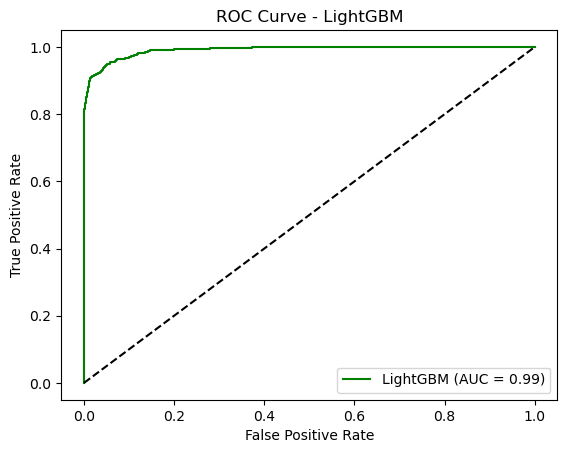

In [46]:
# Import LightGBM
from lightgbm import LGBMClassifier

# Train LightGBM
lgb = LGBMClassifier(
    random_state=42,
    class_weight='balanced',  # handles imbalance
    n_estimators=200,
    learning_rate=0.05
)

lgb.fit(X_train_res, y_train_res)

# Predict
y_pred_lgb = lgb.predict(X_test)
y_prob_lgb = lgb.predict_proba(X_test)[:, 1]

#  Evaluate
print(" LightGBM Results")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lgb))

#  ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {roc_auc_score(y_test, y_prob_lgb):.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()


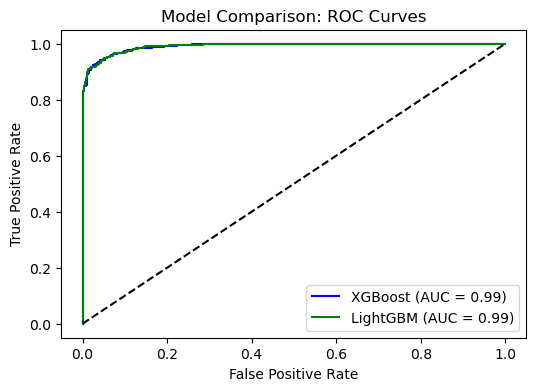

In [47]:
# ROC curves side-by-side
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_prob):.2f})", color='blue')
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {roc_auc_score(y_test, y_prob_lgb):.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Comparison: ROC Curves")
plt.legend()
plt.show()


In [48]:
import joblib
joblib.dump(lgb, 'churn_model_lightgbm.pkl')


['churn_model_lightgbm.pkl']